In [1]:
! ln -s '~/data/*.txt' '/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data'

ln: failed to create symbolic link '/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/*.txt': File exists


In [2]:
! python3 -m pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import os

import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


In [4]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [5]:
!pip install Mecab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# 데이터 준비와 확인

In [8]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 로더 구성

In [56]:
from konlpy.tag import Mecab
from MeCab import Tagger

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [57]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [58]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [59]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [64]:
print(word_to_index['.'])  # 4가 출력됩니다.

# 인덱스 0,1,2,3 에는 아무것도 할당되어있지 않습니다. 

4


In [65]:
# 비어있는 것들에 할당

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[3])

<UNUSED>


In [66]:
# 인코딩된 텍스트가 제대로 디코딩되는지 확인

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [67]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


여기서 최대 길이를 

In [68]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


패딩문자는 최대 길이에 못 미치는 문장이 왔을 때 그 길이를 최대 길이와 같도록 채워주는 단어이다. 이 패딩문자는 문장의 앞 혹은 뒤에 넣는데, 순차적으로 데이터를 처리하는 RNN에서는 가장 마지막에 놓인 단어가 영향력이 크므로 패딩문자를 앞에서부터 채우는 것이 바람직하다.

# 모델 및 validation set 구성

## RNN 모델

In [69]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 32로 하였습니다. (변경 가능)
model_1.add(tf.keras.layers.Dense(32, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [70]:
# 검증 데이터셋은 학습용 데이터의 20% 정도가 적당하다고 한다. 따라서 약 20% 에 근접한 3만개로 둔다.

# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [71]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 9ms/step - loss: 0.4618 - accuracy: 0.7829 - val_loss: 0.3504 - val_accuracy: 0.8467
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3338 - accuracy: 0.8582 - val_loss: 0.3437 - val_accuracy: 0.8518
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3110 - accuracy: 0.8682 - val_loss: 0.3422 - val_accuracy: 0.8517
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2951 - accuracy: 0.8756 - val_loss: 0.3494 - val_accuracy: 0.8479
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2802 - accuracy: 0.8829 - val_loss: 0.3499 - val_accuracy: 0.8525
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2648 - accuracy: 0.8898 - val_loss: 0.3528 - val_accuracy: 0.8518
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2500 - accuracy: 0.8959 - val_loss: 0.3864 - val_accuracy: 0.8499
Epoch 

In [72]:
# 테스트셋으로 평가

results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6941 - accuracy: 0.8312 - 4s/epoch - 3ms/step
[0.6941249966621399, 0.8312142491340637]


## CNN 모델

In [91]:
vocab_size = 10000  # 어휘 사전의 크기입니다.
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_16 (Conv1D)          (None, None, 16)          1808      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 16)              

In [92]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 6ms/step - loss: 0.5153 - accuracy: 0.7224 - val_loss: 0.3558 - val_accuracy: 0.8451
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3267 - accuracy: 0.8610 - val_loss: 0.3382 - val_accuracy: 0.8544
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2886 - accuracy: 0.8799 - val_loss: 0.3388 - val_accuracy: 0.8545
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2561 - accuracy: 0.8971 - val_loss: 0.3489 - val_accuracy: 0.8526
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2229 - accuracy: 0.9143 - val_loss: 0.3668 - val_accuracy: 0.8523
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1876 - accuracy: 0.9301 - val_loss: 0.3949 - val_accuracy: 0.8474
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1550 - accuracy: 0.9447 - val_loss: 0.4324 - val_accuracy: 0.8419
Epoch 

In [96]:
#  테스트셋으로 평가

results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0614 - accuracy: 0.8128 - 3s/epoch - 2ms/step
[1.0614217519760132, 0.8127835392951965]


## MaxPooling

In [95]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 4)           40000     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 4)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 8)                 40        
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [97]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 5ms/step - loss: 0.6568 - accuracy: 0.6916 - val_loss: 0.5706 - val_accuracy: 0.7788
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.4764 - accuracy: 0.8043 - val_loss: 0.4180 - val_accuracy: 0.8148
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3894 - accuracy: 0.8323 - val_loss: 0.3882 - val_accuracy: 0.8255
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3586 - accuracy: 0.8459 - val_loss: 0.3797 - val_accuracy: 0.8294
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3398 - accuracy: 0.8549 - val_loss: 0.3773 - val_accuracy: 0.8325
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3263 - accuracy: 0.8617 - val_loss: 0.3782 - val_accuracy: 0.8325
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3157 - accuracy: 0.8668 - val_loss: 0.3817 - val_accuracy: 0.8325
Epoch 

In [98]:
#  테스트셋으로 평가

results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4314 - accuracy: 0.8230 - 2s/epoch - 2ms/step
[0.4313792586326599, 0.8229957222938538]


# RNN 모델로 다시 구하기

위의 3가지 모델을 사용했을 때 같은 조건에서 가장 성능이 나았던 RNN 모델을 다듬어보자.

LSTM units를 늘린 경우


In [102]:
# 하이퍼 파라미터를 바꿔서 다시 시도한다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                20736     
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 182,849
Trainable params: 182,849
Non-trainable params: 0
_________________________________________________________________


In [103]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 9ms/step - loss: 0.4632 - accuracy: 0.7719 - val_loss: 0.3496 - val_accuracy: 0.8472
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3373 - accuracy: 0.8558 - val_loss: 0.3431 - val_accuracy: 0.8508
Epoch 3/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3161 - accuracy: 0.8664 - val_loss: 0.3422 - val_accuracy: 0.8512
Epoch 4/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3037 - accuracy: 0.8730 - val_loss: 0.3484 - val_accuracy: 0.8491
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2919 - accuracy: 0.8785 - val_loss: 0.3476 - val_accuracy: 0.8502
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2785 - accuracy: 0.8843 - val_loss: 0.3559 - val_accuracy: 0.8448
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2619 - accuracy: 0.8914 - val_loss: 0.3509 - val_accuracy: 0.8494
Epoch 

워드 벡터의 차원 수를 늘린 경우

In [104]:
# 하이퍼 파라미터를 바꿔서 다시 시도한다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 329,409
Trainable params: 329,409
Non-trainable params: 0
_________________________________________________________________


In [105]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 10ms/step - loss: 0.4490 - accuracy: 0.7861 - val_loss: 0.3494 - val_accuracy: 0.8499
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3296 - accuracy: 0.8602 - val_loss: 0.3404 - val_accuracy: 0.8527
Epoch 3/20
227/227 [==============================] - 1s 7ms/step - loss: 0.3055 - accuracy: 0.8720 - val_loss: 0.3476 - val_accuracy: 0.8509
Epoch 4/20
227/227 [==============================] - 1s 7ms/step - loss: 0.2843 - accuracy: 0.8820 - val_loss: 0.3398 - val_accuracy: 0.8525
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2673 - accuracy: 0.8908 - val_loss: 0.3478 - val_accuracy: 0.8515
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2478 - accuracy: 0.8990 - val_loss: 0.3629 - val_accuracy: 0.8515
Epoch 7/20
227/227 [==============================] - 1s 7ms/step - loss: 0.2301 - accuracy: 0.9061 - val_loss: 0.3674 - val_accuracy: 0.8504
Epoch

batch size를 줄인 경우

In [106]:
# 하이퍼 파라미터를 바꿔서 다시 시도한다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_5 (LSTM)               (None, 32)                6272      
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [107]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1816/1816 [==============================] - 13s 6ms/step - loss: 0.3921 - accuracy: 0.8200 - val_loss: 0.3367 - val_accuracy: 0.8530
Epoch 2/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.3116 - accuracy: 0.8657 - val_loss: 0.3340 - val_accuracy: 0.8575
Epoch 3/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2746 - accuracy: 0.8832 - val_loss: 0.3311 - val_accuracy: 0.8604
Epoch 4/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2446 - accuracy: 0.8980 - val_loss: 0.3401 - val_accuracy: 0.8594
Epoch 5/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2197 - accuracy: 0.9087 - val_loss: 0.3688 - val_accuracy: 0.8583
Epoch 6/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1984 - accuracy: 0.9200 - val_loss: 0.3878 - val_accuracy: 0.8550
Epoch 7/20
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1786 - accuracy: 0.9287 - val_loss: 0.4129 - val_ac

세 가지 경우를 종합한다. Epoch가 얼마 되지 않아도 val_loss가 늘어나므로 줄여서 시도한다. 

In [117]:
# 하이퍼 파라미터를 바꿔서 다시 시도한다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 346,945
Trainable params: 346,945
Non-trainable params: 0
_________________________________________________________________


In [118]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 13s 6ms/step - loss: 0.3852 - accuracy: 0.8253 - val_loss: 0.3390 - val_accuracy: 0.8514
Epoch 2/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.3022 - accuracy: 0.8703 - val_loss: 0.3196 - val_accuracy: 0.8614
Epoch 3/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2634 - accuracy: 0.8882 - val_loss: 0.3255 - val_accuracy: 0.8633
Epoch 4/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2332 - accuracy: 0.9028 - val_loss: 0.3392 - val_accuracy: 0.8564
Epoch 5/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2064 - accuracy: 0.9164 - val_loss: 0.3645 - val_accuracy: 0.8549
Epoch 6/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1812 - accuracy: 0.9271 - val_loss: 0.4094 - val_accuracy: 0.8578
Epoch 7/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1582 - accuracy: 0.9363 - val_loss: 0.4546 - val_ac

In [120]:
# 테스트셋으로 평가

results = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6194 - accuracy: 0.8445 - 4s/epoch - 3ms/step
[0.6194473505020142, 0.8444575667381287]


In [121]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


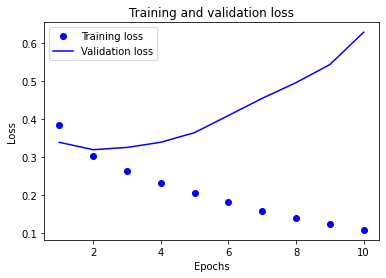

In [122]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

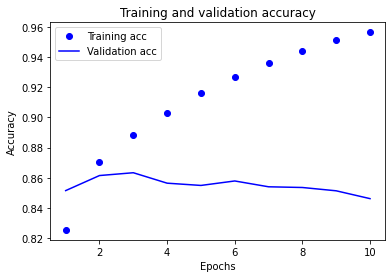

In [123]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

위 결과로 epoch는 3이 적절하다는 사실을 알 수 있다. 따라서 다시 해보면...

In [124]:
# 하이퍼 파라미터를 바꿔서 다시 시도한다.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm_10 (LSTM)              (None, 64)                24832     
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                                 
Total params: 346,945
Trainable params: 346,945
Non-trainable params: 0
_________________________________________________________________


In [125]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
1816/1816 [==============================] - 13s 6ms/step - loss: 0.3856 - accuracy: 0.8237 - val_loss: 0.3397 - val_accuracy: 0.8506
Epoch 2/3
1816/1816 [==============================] - 11s 6ms/step - loss: 0.3033 - accuracy: 0.8707 - val_loss: 0.3192 - val_accuracy: 0.8613
Epoch 3/3
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2629 - accuracy: 0.8898 - val_loss: 0.3200 - val_accuracy: 0.8616


In [126]:
# 테스트셋으로 평가

results = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3281 - accuracy: 0.8574 - 4s/epoch - 3ms/step
[0.32809677720069885, 0.8573957085609436]


# 학습된 Embedding layer 분석

In [128]:
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [129]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/word2vec_1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [131]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['추천']
vector

array([ 0.03683658, -0.0971084 ,  0.07998341,  0.07281753, -0.1147862 ,
       -0.10304193,  0.03124219, -0.01816459,  0.11426818,  0.06344908,
       -0.07482395,  0.10273682, -0.0632188 ,  0.14141493,  0.08515199,
       -0.05612532,  0.05755341,  0.17269255,  0.07847835,  0.08741249,
        0.13578814,  0.07574377,  0.10940658, -0.06959734,  0.16031128,
       -0.0938124 , -0.13187625,  0.08096723, -0.11262145, -0.08729053,
       -0.08283718, -0.06959382], dtype=float32)

In [132]:
word_vectors.similar_by_word("추천")

[('펭귄', 0.9661002159118652),
 ('되돌아보', 0.9640968441963196),
 ('끝장', 0.9636724591255188),
 ('아려', 0.9624024629592896),
 ('따스', 0.9614100456237793),
 ('해냈', 0.9608798027038574),
 ('울림', 0.9597383737564087),
 ('슬퍼요', 0.9592797160148621),
 ('아름다워요', 0.9590615034103394),
 ('눈물나', 0.958731472492218)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [133]:
from gensim.models import KeyedVectors

word2vec_path = '/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/word2vec_ko.model' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [144]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['추천']
print(len(vector))
vector

100


array([-3.58269382e+00,  6.40746236e-01, -1.53450882e+00, -2.83654690e+00,
       -2.43265837e-01, -1.31797469e+00,  1.63202512e+00, -8.36927593e-01,
       -4.50154334e-01,  1.17610300e+00,  2.14729571e+00,  8.05107117e-01,
       -1.16370988e+00, -1.79936600e+00,  2.15869141e+00,  1.20916033e+00,
        1.75766662e-01, -1.87189877e+00,  1.13454318e+00, -3.67186666e-01,
       -1.80770779e+00,  1.07534111e+00,  4.37266454e-02, -6.28859043e+00,
       -2.44364858e+00, -1.31413686e+00, -1.19013870e+00, -1.44853306e+00,
        8.38042080e-01, -1.38884342e+00, -5.00943327e+00,  4.11244154e+00,
        1.66292834e+00, -8.70976925e-01, -1.95594096e+00,  2.33000755e+00,
        3.58346216e-02, -6.45447910e-01,  9.93417680e-01,  2.24508429e+00,
       -2.20631289e+00,  1.40667903e+00, -1.52458799e+00, -8.92117560e-01,
       -1.75378513e+00, -1.09110498e+00,  6.55998826e-01, -6.79832339e-01,
        2.88972211e+00,  3.91617030e-01,  2.32772565e+00, -1.11888373e+00,
        3.78289253e-01, -

In [137]:
word2vec.similar_by_word("추천")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('천거', 0.7103838920593262),
 ('초빙', 0.687961220741272),
 ('초청', 0.6826258897781372),
 ('위촉', 0.6571412086486816),
 ('포상', 0.6499664783477783),
 ('선출', 0.6489635705947876),
 ('소개', 0.6427397727966309),
 ('임명', 0.6394351720809937),
 ('등용', 0.6328903436660767),
 ('추대', 0.6315879225730896)]

이전의 결과와는 달리 영화와는 전혀 관계없는 의미로 유사한 단어들이 나열되고 있다.

In [153]:
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [157]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# model 설계 
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 100)         1000000   
                                                                 
 lstm_12 (LSTM)              (None, 64)                42240     
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


In [158]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
1816/1816 [==============================] - 13s 6ms/step - loss: 0.4151 - accuracy: 0.8061 - val_loss: 0.3445 - val_accuracy: 0.8484
Epoch 2/3
1816/1816 [==============================] - 11s 6ms/step - loss: 0.3130 - accuracy: 0.8655 - val_loss: 0.3301 - val_accuracy: 0.8580
Epoch 3/3
1816/1816 [==============================] - 12s 7ms/step - loss: 0.2761 - accuracy: 0.8832 - val_loss: 0.3290 - val_accuracy: 0.8625


In [160]:
#  테스트셋으로 평가

results = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3373 - accuracy: 0.8593 - 4s/epoch - 3ms/step
[0.33734267950057983, 0.8592672348022461]


In [161]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path2 = '/content/drive/MyDrive/아이펠 데이터/sentiment_classification/data/word2vec_2.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [162]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector = word_vectors['추천']
vector

array([-3.606924  ,  0.66163373, -1.630613  , -2.7248912 , -0.21215604,
       -1.3284479 ,  1.7047087 , -0.850731  , -0.47376782,  1.2628481 ,
        2.180031  ,  0.75528514, -1.1280925 , -1.926974  ,  2.1859221 ,
        1.1420671 ,  0.23162097, -2.0252285 ,  1.0394294 , -0.46877572,
       -1.8265017 ,  1.0216417 ,  0.03297603, -6.2607903 , -2.4298918 ,
       -1.3530211 , -1.2682607 , -1.4734069 ,  0.8002041 , -1.4817423 ,
       -5.1362324 ,  4.1985846 ,  1.5777158 , -0.90939796, -1.956819  ,
        2.2503593 ,  0.09167702, -0.5804335 ,  0.91034424,  2.4594378 ,
       -2.2400112 ,  1.4707326 , -1.2820826 , -0.78983396, -1.846615  ,
       -1.304921  ,  0.64380264, -0.6325787 ,  2.9882832 ,  0.40210694,
        2.3759713 , -1.0066    ,  0.4309378 , -1.2456561 ,  1.4663724 ,
       -2.0310788 , -0.59325814, -0.01222878,  0.15510063,  2.2005265 ,
       -1.538867  ,  0.20867622,  1.244252  ,  0.31029272, -3.3180206 ,
        0.7199367 ,  1.440328  , -4.1748705 ,  1.0264773 , -2.42

In [163]:
word_vectors.similar_by_word("추천")

[('소개', 0.6391516327857971),
 ('선정', 0.6220725178718567),
 ('초대', 0.6108789443969727),
 ('부탁', 0.5986571311950684),
 ('심사', 0.5816296339035034),
 ('선택', 0.5801743268966675),
 ('요청', 0.5671523809432983),
 ('설득', 0.5653015375137329),
 ('평가', 0.5649893879890442),
 ('지도', 0.5458502769470215)]

결과

학습된 Embedding layer : 85.7%의 정확도

한국어 Word2Vec 임베딩 : 85.9%의 정확도

# 회고

이번 노드에서는 영화 리뷰들을 임베딩하여 그 리뷰가 긍정적인 리뷰인지 혹은 부정적인 리뷰인지 분석하는 일을 했다. 리뷰에 쓰인 문장들의 단어들을 인덱스화 하고 이것들을 이용해 학습했다. 여기서 같은 단어를 사용한다 하더라도 맥락에 따라 전혀 다른 의미를 내포하고 있을 수 있다는 점을 기억해야한다. 예를 들어 같은 단어를 사용한 평가라도 영화의 장르에 따라 맥락이 다르고, 리뷰에 쓰인 자연어인 만큼 반어법적인 표현도 많을 수 있기 때문이다. 그러므로 이 맥락을 찾는 것이 중요하다 할 수 있겠다.

처음에 3가지 모델을 테스트해보았는데 RNN 모델이 가장 나은 결과를 보여주어 RNN 모델을 선택했지만 사실 CNN모델이나 MaxPooling 레이어 하나만 쓴 모델도 나쁘지 않은 결과를 보여주었다. 저 두 모델은 RNN 모델보다 훨씬 가벼워서 학습속도가 빠르므로 서로 장단점이 있다고 할 수 있겠다. 하지만 우리는 학습속도는 그리 중요하지 않았으며 이번 노드에서 했던 정도는 크게 오래 걸리지 않고 가능했으므로 RNN 모델을 썼다.

여기서 우리가 학습해 만든 임베딩 레이어와 미리 만들어진 word2vec 임베딩을 사용하는 것 모두 해보았는데 학습으로 만든 레이어는 영화와 관련있는 내용들을 주로 학습한 반면 외부에서 가져온 단어 사전은 일상적인 언어로 되어있는 차이점이 있었다. 예를 들어 '추천' 이라는 단어를 넣었을 때 우리가 학습한 레이어는 좋은 영화와 관련된 단어들을 유사한 단어로 뽑는 반면, 미리 준비된 사전에서는 사전적인 의미로 비슷한 단어들을 가져왔다.

물론 여기까지 본다면 우리가 학습한 레이어가 훨씬 적합하다고 볼 수 있겠지만 저 외부 임베딩을 베이스로 하여 학습을 진행할 수도 있는 것이다. 이렇게 한다면 사전적인 의미를 이미 가지고 있으므로 훨씬 단어에 대한 정확도가 올라갈 것을 기대할 수 있겠다. 실제로 사용해보면 0.2%p 정확도가 올라갔는데 의미가 없진 않지만 큰 차이는 아니라 아쉬웠다.

# Reference

https://wikidocs.net/80437 다양한 모델들